## Notebook to bulk download Planet imagery through the API
Rainey Aberle, Fall 2021

Modified from [Planet Developers API Tutorial](https://developers.planet.com/docs/apis/data/) and Planet Labs GitHub Repository: [planetlabs/notebooks/jupyter-notebooks/orders/](https://github.com/planetlabs/notebooks/tree/master/jupyter-notebooks/orders)


__To-Do:__
- View image footprints before downloading.  
- Implement percent AOI coverage filter for image search

In [1]:
# -----Define paths in directory
# path to planet-snow/
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/' 
# path for saving image downloads
out_path = base_path+'../study-sites/Gulkana/imagery/'

In [2]:
import os
import json
import requests
from requests.auth import HTTPBasicAuth
import time
import datetime
from getpass import getpass
import geopandas as gpd
from pathlib import Path
from shapely import geometry as sgeom
import rasterio as rio
import numpy as np
from planet import api
from planet.api import filters
import sys
# add path to functions
sys.path.insert(1, base_path+'functions/')
import orders

### Define filters for image search

In [3]:
# ----------Area of Interest (AOI)----------
#### OPTION 1: Use geojson.io to create a polygon
#    - Type geojson.io into a new browser page
#    - Draw a RECTANGULAR polygon over your AOI  
#    - Copy only the geometry below
# AOI_box = {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.366355109034046
#             ],
#             [
#               -148.84963989257812,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.440285056170616
#             ],
#             [
#               -148.96774291992188,
#               60.366355109034046
#             ]
#           ]
#         ]
#       }
# AOI_box

POLYGON ((-145.50033398 63.24991222600005, -145.345221689 63.24991222600005, -145.345221689 63.30161320100007, -145.50033398 63.30161320100007, -145.50033398 63.24991222600005))


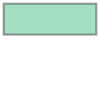

In [4]:
#### OPTION 2: Import an existing shapefile

# Name of your file
# If your shapefile is not currently in this directory, you need to include the full file path in 'file_name' below
AOI_fn = base_path+'../GIS_data/Gulkana_RGI.shp'

# Read in the shapefile
AOI = gpd.read_file(AOI_fn)

# Reproject shapefile to WGS84 if necessary
AOI = AOI.to_crs(4326)
# Reproject to UTM
AOI_UTM = AOI.to_crs(32606)

# File extension index (we don't want the .shp extension in the next line)
i = AOI_fn.index('.shp')

# Convert AOI to geoJSON format and adjust polygon to a rectangular shape 
# Planet only excepts a bounding BOX as a spatial filter, 
# so we need to convert our AOI to a box (if it is not already). 
AOI_box = {u'geometry':
           {u'type': u'Polygon',
            u'coordinates': [[
               [AOI.bounds.minx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.miny[0]]
            ]]
           }
          }

# Convert geojson to a rasterio Shape
AOI_shape = sgeom.shape(AOI_box['geometry'])
print(AOI_shape)
AOI_shape

In [5]:
# ----------Date Range----------
# Format: datetime.datetime(year=YYYY, month=MM, day=DD)
start_date = '2022-04-01'
end_date = '2022-10-01'

# ----------Cloud Cover Filter----------
# Format: percentage (e.g., 50% max cloud cover = 50)
max_cloud_cover = 20

# ----------Area Coverage----------
# Format: percentage (e.g., 50% min AOI area coverage = 50)
area_coverage = 60

# ----------Item Type----------
# See here for possible image ("item") types:
# https://developers.planet.com/docs/apis/data/items-assets/
item_type = "PSScene4Band"

# ----------Asset Type----------
# Each Item Type has a number of asset types to choose from.
# Use the Item Type link above click on your Item Type to view the available Asset Types
asset_type = "analytic_sr"

# ----------AOI clipping----------
# Would you like to clip images to the AOI (True/False)?
# This greatly speeds up the ordering and downloading process.
clip_AOI = True

# ----------Harmonization----------
# option to harmonize PlanetScope imagery to Sentinel-2
harmonize = False # = True to harmonize

### Authentication via basic HTTP

In [6]:
# set API key as environment variable
print('Enter Planet API key:')
API_key = getpass()
os.environ['PL_API_KEY'] = API_key

# Setup the API Key stored as the `PL_API_KEY` environment variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Orders URL
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# Authorize
auth = HTTPBasicAuth(PLANET_API_KEY, '')
response = requests.get(orders_url, auth=auth)
response

Enter Planet API key:
········


<Response [200]>

### Compile, create request, and search the Planet API

In [7]:
# -----Create request
QS_request = orders.build_request(AOI_shape, max_cloud_cover, start_date, end_date, 
                        item_type, asset_type)

# -----Planet API Quick Search using created request
# fire off the POST request
QS_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=QS_request)
# Print resulting image IDs
im_ids = [feature['id'] for feature in QS_result.json()['features']]
print(im_ids)

# -----Check area coverage
# items = orders.search_pl_api(QS_request, limit=500)
# # print([item['geometry'] for item in items])
# # cache the overlaps as a list so we don't have to refetch items
# overlaps = list(orders.get_overlap_shapes_utm(items, AOI_shape))
# print(len(overlaps))

['20220515_205745_34_2426', '20220515_205950_47_2424', '20220515_205952_77_2424', '20220511_205247_76_2414', '20220512_205446_31_2274', '20220513_205657_99_2402', '20220513_205655_71_2402', '20220511_205718_04_2254', '20220511_205715_57_2254', '20220509_210212_55_2407', '20220509_200555_42_2457', '20220509_200557_71_2457', '20220506_201253_27_2435', '20220506_201250_97_2435', '20220502_205142_68_227b', '20220502_205144_99_227b', '20220426_204508_47_2438', '20220424_201149_69_2465', '20220424_201151_99_2465', '20220424_205146_49_227b', '20220424_205144_01_227b', '20220423_201348_83_242d', '20220422_200859_56_2453', '20220419_210055_35_2414', '20220420_210128_07_2403', '20220412_201131_33_2463', '20220412_201129_03_2463', '20220415_205306_97_2403', '20220414_202112_31_225a', '20220413_214718_25_1058', '20220413_203957_28_24a5', '20220413_214719_75_1058', '20220411_202932_84_2251', '20220410_201216_04_2421', '20220410_201218_33_2421', '20220408_200613_12_2435', '20220408_200610_82_2435', 

### Place Order

In [8]:
# build new request
request = orders.build_request_itemIDs(AOI_box, clip_AOI, harmonize, im_ids, item_type, asset_type)
print(request)

# place order
order_url = orders.place_order(orders_url, request, auth)

{'name': 'simple order', 'products': [{'item_ids': ['20220515_205745_34_2426', '20220515_205950_47_2424', '20220515_205952_77_2424', '20220511_205247_76_2414', '20220512_205446_31_2274', '20220513_205657_99_2402', '20220513_205655_71_2402', '20220511_205718_04_2254', '20220511_205715_57_2254', '20220509_210212_55_2407', '20220509_200555_42_2457', '20220509_200557_71_2457', '20220506_201253_27_2435', '20220506_201250_97_2435', '20220502_205142_68_227b', '20220502_205144_99_227b', '20220426_204508_47_2438', '20220424_201149_69_2465', '20220424_201151_99_2465', '20220424_205146_49_227b', '20220424_205144_01_227b', '20220423_201348_83_242d', '20220422_200859_56_2453', '20220419_210055_35_2414', '20220420_210128_07_2403', '20220412_201131_33_2463', '20220412_201129_03_2463', '20220415_205306_97_2403', '20220414_202112_31_225a', '20220413_214718_25_1058', '20220413_203957_28_24a5', '20220413_214719_75_1058', '20220411_202932_84_2251', '20220410_201216_04_2421', '20220410_201218_33_2421', '20

KeyError: 'id'

### Poll for Order Success
- This section outputs the status of the order every ~10 sec. This will take a few minutes... 
- Wait until it outputs `success` to proceed to the next section. It will stop after 30 loops, so try proceeding to the next section if it finishes running and does not output `success`.
- If you are ordering a LOT of images, consider narrowing your date range to download less images at a time. 

In [ ]:
# def poll_for_success(order_url, auth, num_loops=30):
#     count = 0
#     while(count < num_loops):
#         count += 1
#         r = requests.get(order_url, auth=auth)
#         response = r.json()
#         state = response['state']
#         print(state)
#         end_states = ['success', 'failed', 'partial']
#         if state in end_states:
#             break
#         time.sleep(10)
        
# poll_for_success(order_url, auth)

### View Results

In [ ]:
# r = requests.get(order_url, auth=auth)
# response = r.json()
# results = response['_links']['results']

# [r['name'] for r in results]

### Download each asset individually

In [ ]:
# # make directory for images using image dates
# out_im_path = outpath+start_date+'_'+end_date
# if os.path.isdir(stitch_path)==0:
#     os.mkdir(stitch_path)
#     print(stitch_path+' directory made')

# # define function to download results
# def download_results(results, overwrite=False):
#     results_urls = [r['location'] for r in results]
#     results_names = [r['name'] for r in results]
#     print('{} items to download'.format(len(results_urls)))
    
#     for url, name in zip(results_urls, results_names):
#         path = Path(os.path.join(out_folder,name)) #pathlib.Path(os.path.join('data', name))
        
#         if overwrite or not path.exists():
#             print('downloading {} to {}'.format(name, path))
#             r = requests.get(url, allow_redirects=True)
#             path.parent.mkdir(parents=True, exist_ok=True)
#             open(path, 'wb').write(r.content)
#         else:
#             print('{} already exists, skipping {}'.format(path, name))
            
# # download images!
# download_results(results)

### Visualize downloaded images

In [ ]:
# define helpful functions for visualizing downloaded imagery
# def show_rgb(img_file):
#     with rio.open(img_file) as src:
#         b,g,r,n = src.read()

#     rgb = np.stack((r,g,b), axis=0)
#     show(rgb/rgb.max())
    
# def show_gray(img_file):
#     with rio.open(img_file) as src:
#         g = src.read(1)
#     show(g/g.max())
    
# # Replace this path with your image file path
# img_file = out_folder+'2021-04-20_2021-08-25/PSScene4Band/20211007_202318_88_245c_3B_AnalyticMS_clip.tif'
# show_rgb(img_file)

## You did it!

<div>
<img src="../inputs/sandy-cheeks.jpeg" width="400"/>
</div>